In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
import itertools

from format_data import create_dataframe
from preprocess import preprocess_supervised, OutputColumn

In [2]:
def split_target_from_dataset(Db, target='output'):  # Remove target col
    y = Db[target]
    X = Db.drop(columns=[target])
    return X, y

In [3]:
def save_model(pipeline, model_filepath):
    joblib.dump(pipeline, model_filepath)

In [4]:
data_file_path="welddb/welddb.data"
model_file_path = 'models/xgboost_model.pkl'
target = OutputColumn.yield_strength

In [5]:
print("Loading the dataset")
Db = create_dataframe(data_file_path)
print("Preprocessing")
Db = preprocess_supervised(Db, target)

print("Split target from the dataset")
X, y = split_target_from_dataset(Db)

Loading the dataset
Preprocessing
We retain only the rows with output values Yield strength / MPa, that is 47.215496% of the dataset


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Split target from the dataset


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\natha\AppData\Local\Packages\Py

In [6]:
print("Train/Test split")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

Train/Test split


In [7]:
print("Creating Pipelines")
pipeline_linreg = Pipeline([('preprocesser', PolynomialFeatures(2)),('model', SGDRegressor())])

Creating Pipelines


In [8]:
def best_parameters_tuple(D):
    for key in D:
        if isinstance(D[key],dict):
            D[key] = best_parameters_tuple(D[key])
        else:
            D[key] = [D[key]]
        
    best_parameter = min(D, key= lambda x:abs(D[x][-1]))
    return [best_parameter, *D[best_parameter]]
        

In [9]:
def evaluate_regression(pipeline, param_grid):

    print("Performing Evaluation with Cross-Validation")
    best_parameters_ids = [0]
    features_list = []
    best_scoring_list = []

    while len(best_parameters_ids) < X_train.shape[1]:
        scoring_dict = {}
        for k in best_parameters_ids:
            scoring_dict[k] = {}
            temp_best_parameters_ids = list(set(best_parameters_ids) - set([k]))
            temp_exploration = list(set(range(X_train.shape[1])) - set(temp_best_parameters_ids))
            for i,j in list(itertools.combinations(temp_exploration, 2)):
                grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                X_train_temp = np.take(X_train, temp_best_parameters_ids + [i,j], 1)
                grid_search.fit(X_train_temp, y_train)
                scoring_dict[k].update({i: {j : grid_search.best_score_}})

        [k,i,j,score] = best_parameters_tuple(scoring_dict)
        best_parameters_ids = list(set(best_parameters_ids) - set([k])) +[i,j]
        features_list.append(best_parameters_ids)
        best_scoring_list.append(score)
        print(len(best_parameters_ids), '/', X_train.shape[1])

    best_scoring_list = np.abs(np.array(best_scoring_list))

    best_score_id = 0
    best_score = best_scoring_list[0]
    for id in range(1, len(best_scoring_list)):
        if best_scoring_list[id] <= 0.95*best_score:
            best_score_id = id
            best_score = best_scoring_list[id]

    optimal_features = features_list[best_score_id]

    plt.plot(best_scoring_list)
    plt.xlabel("nb_features")
    plt.ylabel("Validation MSE")
    plt.show()

    print("Best features: ", [Db.keys()[x] for x in optimal_features])
    print("Best score: ", best_scoring_list[best_score_id])

    X_train_temp = np.take(X_train, optimal_features, 1)
    X_test_temp = np.take(X_test, optimal_features, 1)
    grid_search = GridSearchCV(pipeline, {}, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    grid_search.fit(X_train_temp, y_train)

    test_score = grid_search.score(X_test_temp, y_test)
    print("Val set score (L2) with best model: ",  - grid_search.best_score_)
    print("Test set score (L2) with best model: ", - test_score)

    y_pred = grid_search.predict(X_test_temp)

    # Plot the predicted values against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')  # Scatter plot of predicted vs actual
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')  # Line for perfect predictions
    
    # Set equal scaling
    plt.xlim(min(y_test), max(y_test))
    plt.ylim(min(y_test), max(y_test))
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio

    plt.title('Predicted vs Actual values of y_test')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.grid()
    plt.show()

Performing Evaluation with Cross-Validation
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


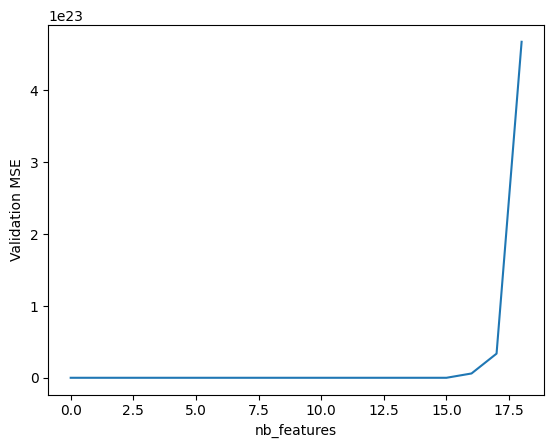

Best features:  ['Post weld heat treatment temperature / °C', 'Manganese concentration / (weight%)', 'Phosphorus concentration / (weight%)', 'Type of weld_GTAA', 'Molybdenum concentration / (weight%)', 'Voltage / V', 'Type of weld_MMA', 'Chromium concentration / (weight%)', 'Type of weld_SAA', 'Heat input / kJmm-1', 'Sulphur concentration / (weight%)']
Best score:  4858.4884216745895
Val set score (L2) with best model:  4909.744743500612
Test set score (L2) with best model:  8218.104088973825


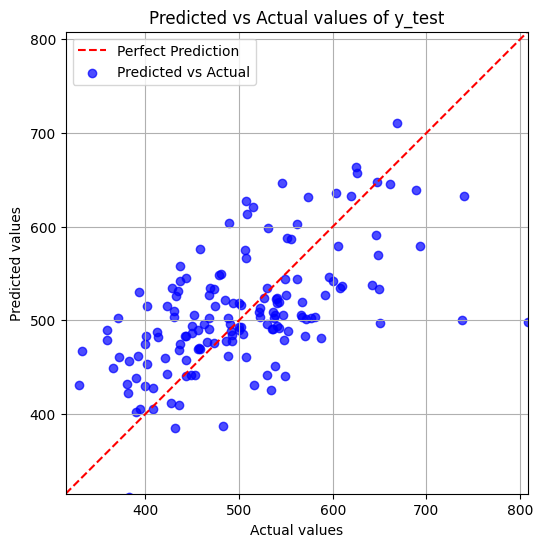

In [10]:
evaluate_regression(pipeline_linreg, {})

In [11]:
def evaluate_regression_no_plots(pipeline, param_grid):

    best_parameters_ids = [0]
    best_scoring_list = []
    features_list = []

    while len(best_parameters_ids) < X_train.shape[1]:
        scoring_dict = {}
        for k in best_parameters_ids:
            scoring_dict[k] = {}
            temp_best_parameters_ids = list(set(best_parameters_ids) - set([k]))
            temp_exploration = list(set(range(X_train.shape[1])) - set(temp_best_parameters_ids))
            for i,j in list(itertools.combinations(temp_exploration, 2)):
                grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                X_train_temp = np.take(X_train, temp_best_parameters_ids + [i,j], 1)
                grid_search.fit(X_train_temp, y_train)
                scoring_dict[k].update({i: {j : grid_search.best_score_}})

        [k,i,j,score] = best_parameters_tuple(scoring_dict)
        best_parameters_ids = list(set(best_parameters_ids) - set([k])) +[i,j]
        features_list.append(best_parameters_ids)
        best_scoring_list.append(score)
        print(len(best_parameters_ids), '/', X_train.shape[1])
    
    best_scoring_list = np.abs(np.array(best_scoring_list))

    best_score_id = 0
    best_score = best_scoring_list[0]
    for id in range(1, len(best_scoring_list)):
        if best_scoring_list[id] <= 0.95*best_score:
            best_score_id = id
            best_score = best_scoring_list[id]
            
    optimal_features = features_list[best_score_id]

    print("Best features: ", optimal_features)
    return best_scoring_list[best_score_id]

In [12]:
list_scores = []
for i in range(1,5):
    pipeline_linreg = Pipeline([('preprocesser', PolynomialFeatures(i)),('model', SGDRegressor())])
    list_scores.append(evaluate_regression_no_plots(pipeline_linreg, {}))

2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Best features:  [10, 2, 7, 3, 19]
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Best features:  [2, 3, 7, 10, 11, 13, 19]


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


2 / 20


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\n

3 / 20


C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\n

4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Best features:  [2, 7, 1, 19]
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
Best features:  [1, 2, 19]


[6677.815046664863, 5167.620808291789, 5436.093039981248, 6423.4206994680735]
[1, 2, 3, 4]


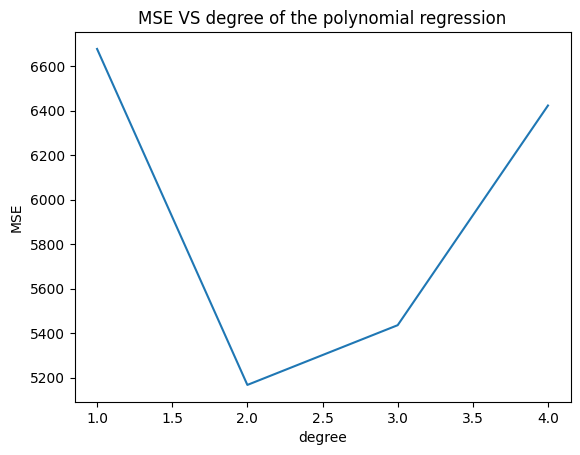

In [17]:
print(list_scores)
print(list(range(1,5)))
plt.plot(list(range(1,5)),list_scores)
plt.title("MSE VS degree of the polynomial regression")
plt.xlabel("degree")
plt.ylabel("MSE")
plt.show()
